# HOMEWORK 5

In this homework you are going to implement the **Floyd-Steinberg dithering** algorithm. Dithering, in general, means that we are adding noise to the signal (in our case digital image) in order to perceive it better. In other words, by adding the noise the objective quality will be worse but the subjective quality will be better (i.e. the image will "look" better).

The details of FS dithering can be found in this [wiki](https://en.wikipedia.org/wiki/Floyd%E2%80%93Steinberg_dithering) page. In order to implement the dithering, we will implement the following steps:
* Define colour pallette
* Quantize the image to obtain the baseline and compute the average quantization error
* Implement FS dithering and compute the average quantization error

You will also have to answer the question at the end of this notebook.

Note: In this homework, you will have the chance to earn some extra points. See the "Bonus" section at the end of the notebook. Good luck!

As always, you are encouraged to use your own images :-)

In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [8, 6]

Let's load the image.

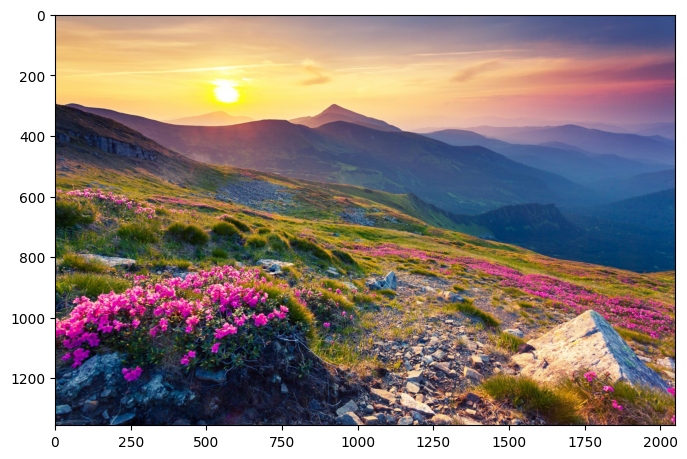

In [2]:
# Load image
img = cv2.imread('mountains.jpg')
# Convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Plot it
plt.imshow(img)

Let's start with gray tones first.

In [3]:
# Black, dark gray, light gray, white
colors = np.array([[0, 0, 0],
                   [64, 64, 64],
                   [192, 192, 192],
                   [255, 255, 255]])

Using the colour pallette, let's quantize the original image.

In [4]:
# Prepare for quantization
rows, cols, channels = img.shape
quantized = np.zeros_like(img)

# Cast the image to float
img = img.astype(np.float32)

# Apply quantization
for r in range(rows):
    for c in range(cols):
        # Extract the original pixel value
        pixel = img[r, c, :]
        
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        distances = np.sum((pixel - colors)**2, axis=1)**0.5
        new_pixel = colors[np.argmin(distances)]
        
        # Apply quantization
        quantized[r, c, :] = new_pixel

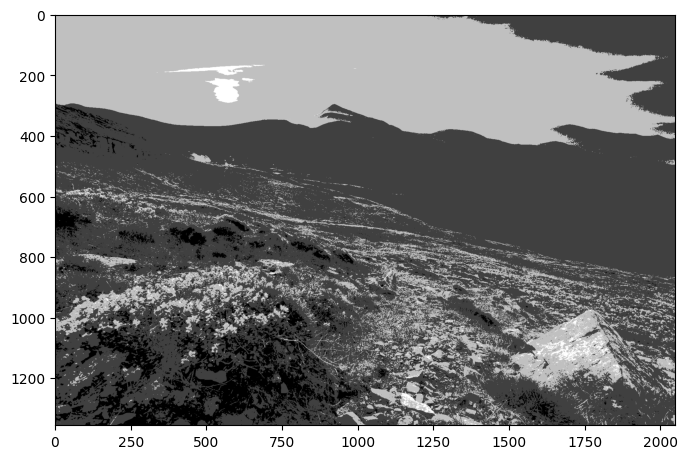

In [5]:
# Show quantized image (don't forget to cast back to uint8)
plt.imshow(quantized)

In [6]:
# Same with broadcast
colors_broadcast = np.resize(colors, (*img.shape[:-1], *colors.shape))
img_broadcast = np.expand_dims(img, axis=-2)
distances = np.sum((img_broadcast - colors_broadcast)**2, axis=-1)**0.5
quantized = colors[np.argmin(distances, axis=-1)]
print(quantized.shape)

(1356, 2048, 3)


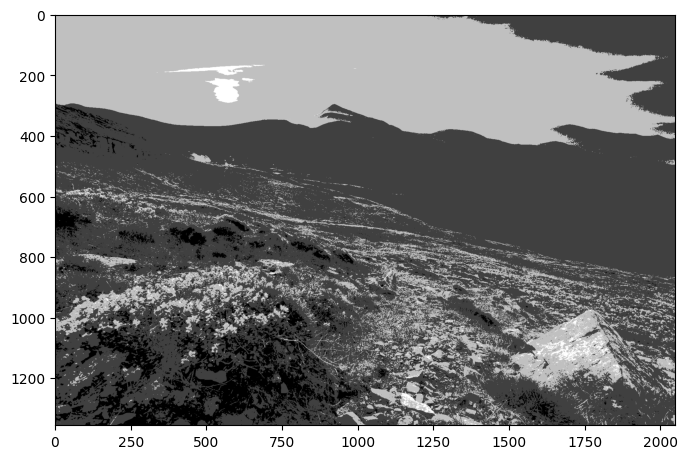

In [7]:
# Show quantized image (don't forget to cast back to uint8)
plt.imshow(quantized)

In [8]:
# Compute average quantization error
avg_quant_error = np.mean(np.abs(quantized - img))
avg_quant_error

37.11982263435657

In [9]:
# Color rmse
color_errors = np.sum((quantized - img)**2, axis=-1)**0.5 # euclidean distances between colors
avg_quant_error = np.mean(color_errors)
avg_quant_error

72.86338371369553

In [10]:
# PSNR - Peak Signal to Noise Ratio
mse = np.mean((quantized - img)**2)
avg_quant_error = 10 * np.log10(255**2/mse)
print('PSNR (dB):', avg_quant_error)

PSNR (dB): 14.951476637392993


#### Floyd-Steinberg Dithering
We are now going to implement the FS dithering and compare it to the optimally quantized image we have calculated above.

In [11]:
# Make a temporal copy of the original image, we will need it for error diffusion
img_tmp = np.copy(img)
dithering = np.zeros_like(img)

dither_matrix = np.array(
    [[0, 0, 7],
     [3, 5, 1]],
     dtype=np.float32
)
dither_matrix = np.expand_dims(dither_matrix / 16, axis=-1)

for r in range(1, rows-1):
    for c in range(1, cols-1):
        # Extract the original pixel value
        pixel = img_tmp[r, c, :]
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        distances = np.sum((pixel - colors)**2, axis=1)**0.5
        new_pixel = colors[np.argmin(distances)]
        
        # Compute quantization error
        quant_error = pixel - new_pixel
        
        # Diffuse the quantization error accroding to the FS diffusion matrix
        # Note: You may need more than one line of code here
        img_tmp[r:r+2, c-1:c+2, :] = img_tmp[r:r+2, c-1:c+2, :] + dither_matrix * quant_error
        
        # Apply dithering
        dithering[r, c, :] = new_pixel

dithering = dithering.astype(np.float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<Axes: >, <matplotlib.image.AxesImage at 0x2684318dfa0>)

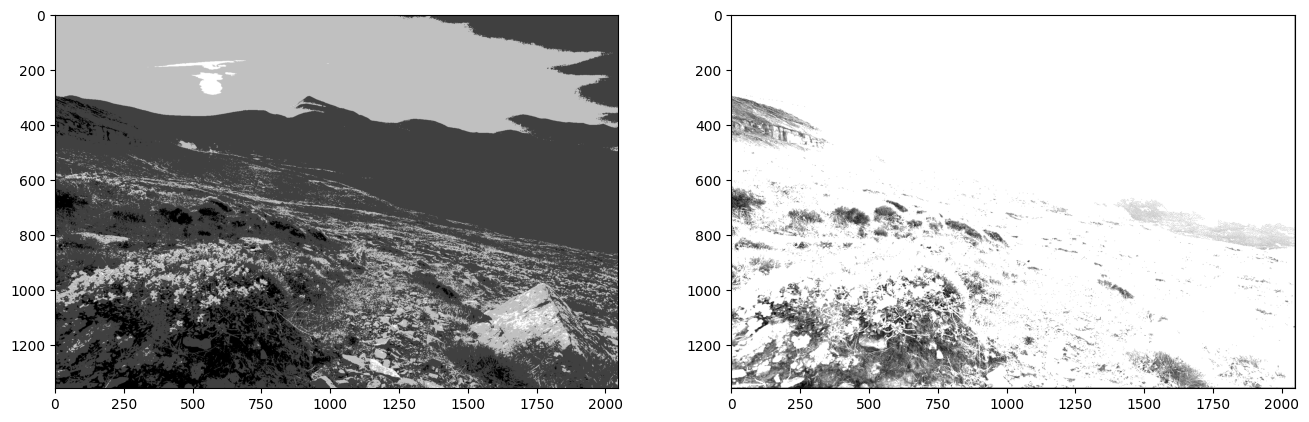

In [12]:
# Show quantized image (don't forget to cast back to uint8)
plt.figure(figsize=(16,12))
plt.subplot(121), plt.imshow(quantized)   # optimally quantized
plt.subplot(122), plt.imshow(dithering)   # dithering

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


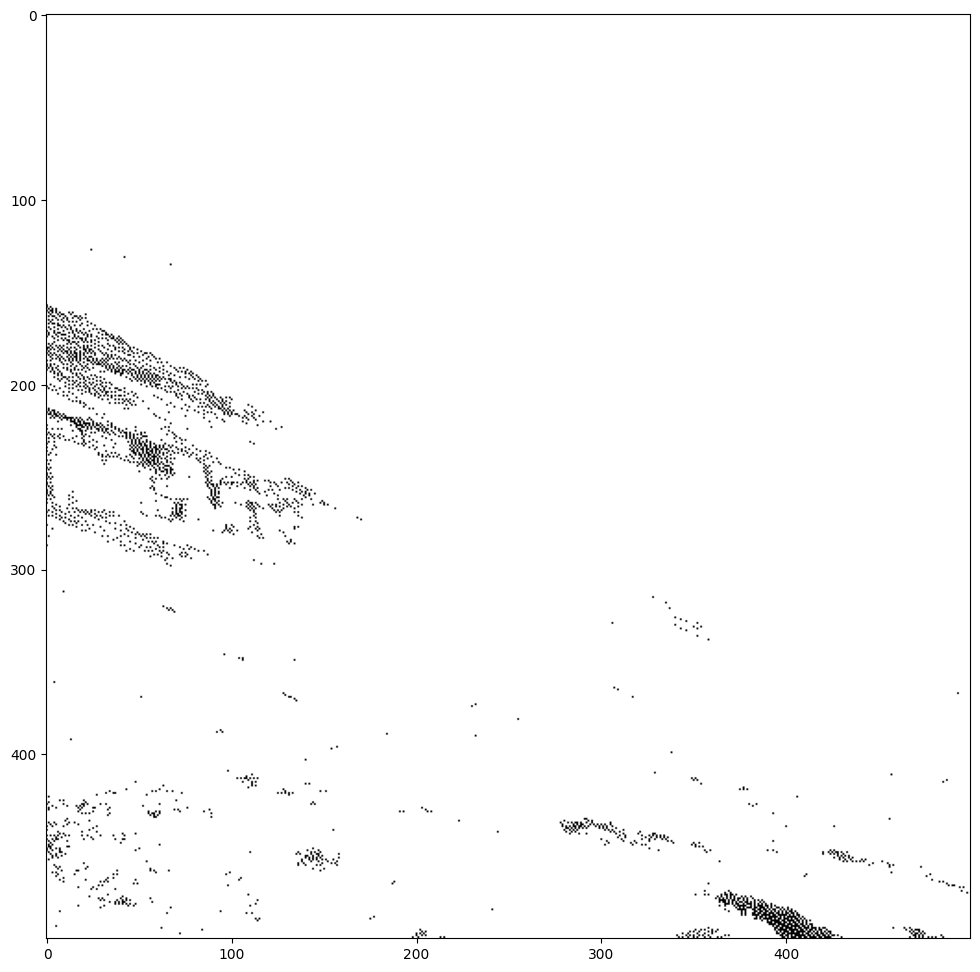

In [13]:
plt.figure(figsize=(16,12))
plt.imshow(dithering[200:700, 200:700])   # dithering

In [14]:
# Compute average quantization error for dithered image
# PNSR
mse = np.mean((dithering - img)**2)
avg_dith_error = 10 * np.log10(255**2/mse)
print('PSNR (dB):', avg_dith_error)

PSNR (dB): 13.41475440137097


### Questions
* Which image has higher quantization error? Optimally quantized or dithered?
* Which image looks better to you?
* Can you repeat the same process using only two colours: black and white? Show me :-)

### Answers

- The image quantized without dithering has lower quantization error, because MSE is optimal when for each pixel we choose the closest color from pallette. With dithering we add extra noise so the chosen color is not always the closest, thus the error is almost always higher.
- The image with dithering looks almost perfect, because it has high resolution and on such scale dithering artifacts are invisible and it looks as if the image had real gradients.
- Changing the pallette should be enough for my solution:

Quantized shape: (1356, 2048, 3)


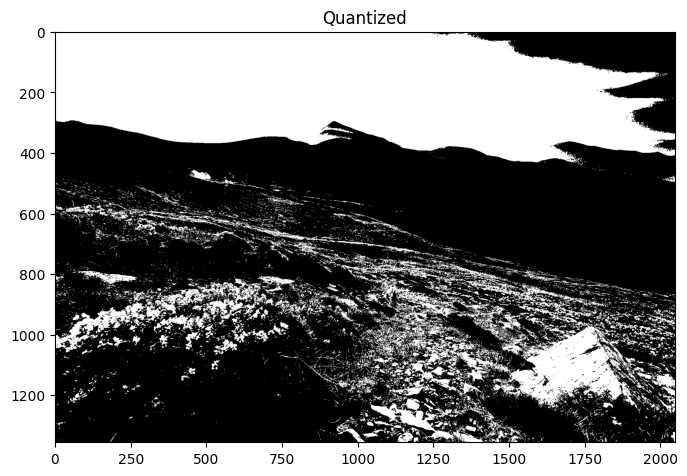

In [15]:
# Black, dark gray, light gray, white
colors = np.array([[0, 0, 0],
                   [255, 255, 255]])

# Quantization with broadcast
def quantize(img, colors):
    colors_broadcast = np.resize(colors, (*img.shape[:-1], *colors.shape))
    img_broadcast = np.expand_dims(img, axis=-2)
    distances = np.sum((img_broadcast - colors_broadcast)**2, axis=-1)**0.5
    quantized = colors[np.argmin(distances, axis=-1)]

    print('Quantized shape:', quantized.shape)
    plt.imshow(quantized), plt.title('Quantized')

    return quantized

quantized = quantize(img, colors)

In [16]:
# PSNR - Peak Signal to Noise Ratio
def show_psnr(quantized, img):
    mse = np.mean((quantized - img)**2)
    avg_quant_error = 10 * np.log10(255**2/mse)
    print('PSNR (dB):', avg_quant_error)

show_psnr(quantized, img)

PSNR (dB): 9.082262364015385


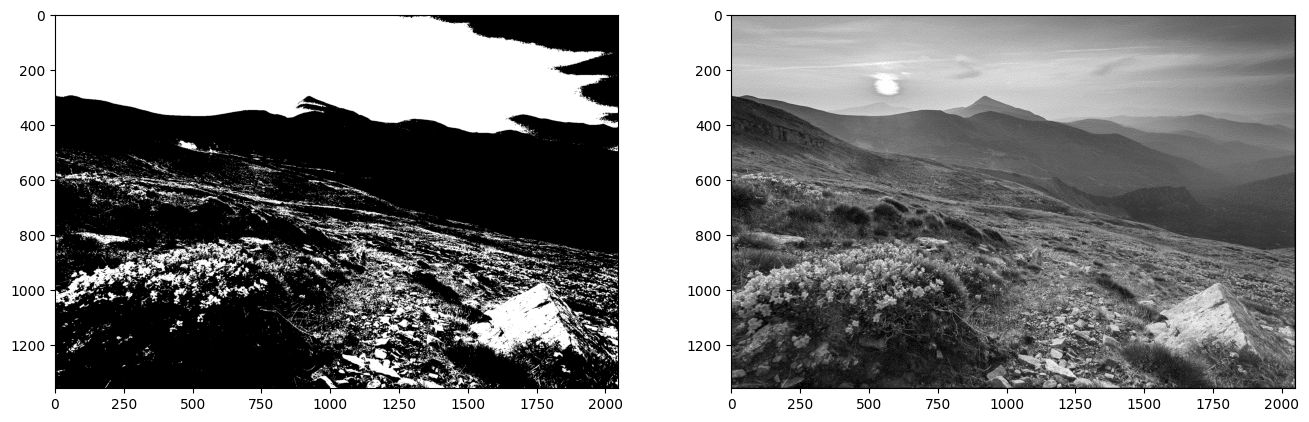

In [17]:
def dither(img, colors):
    # Make a temporal copy of the original image, we will need it for error diffusion
    img_tmp = np.copy(img)
    dithering = np.zeros_like(img)

    dither_matrix = np.array(
        [[0, 0, 7],
        [3, 5, 1]],
        dtype=np.float32
    )
    dither_matrix = np.expand_dims(dither_matrix / 16, axis=-1)

    for r in range(1, rows-1):
        for c in range(1, cols-1):
            # Extract the original pixel value
            pixel = img_tmp[r, c, :]
            # Find the closest colour from the pallette (using absolute value/Euclidean distance)
            # Note: You may need more than one line of code here
            distances = np.sum((pixel - colors)**2, axis=1)**0.5
            new_pixel = colors[np.argmin(distances)]
            
            # Compute quantization error
            quant_error = pixel - new_pixel
            
            # Diffuse the quantization error accroding to the FS diffusion matrix
            # Note: You may need more than one line of code here
            img_tmp[r:r+2, c-1:c+2, :] = img_tmp[r:r+2, c-1:c+2, :] + dither_matrix * quant_error
            
            # Apply dithering
            dithering[r, c, :] = new_pixel

    dithering = dithering.astype(np.uint8)

    # Show quantized image (don't forget to cast back to uint8)
    plt.figure(figsize=(16,12))
    plt.subplot(121), plt.imshow(quantized)   # optimally quantized
    plt.subplot(122), plt.imshow(dithering)   # dithering

    return dithering

dithering = dither(img, colors)

Number of colors used:  2


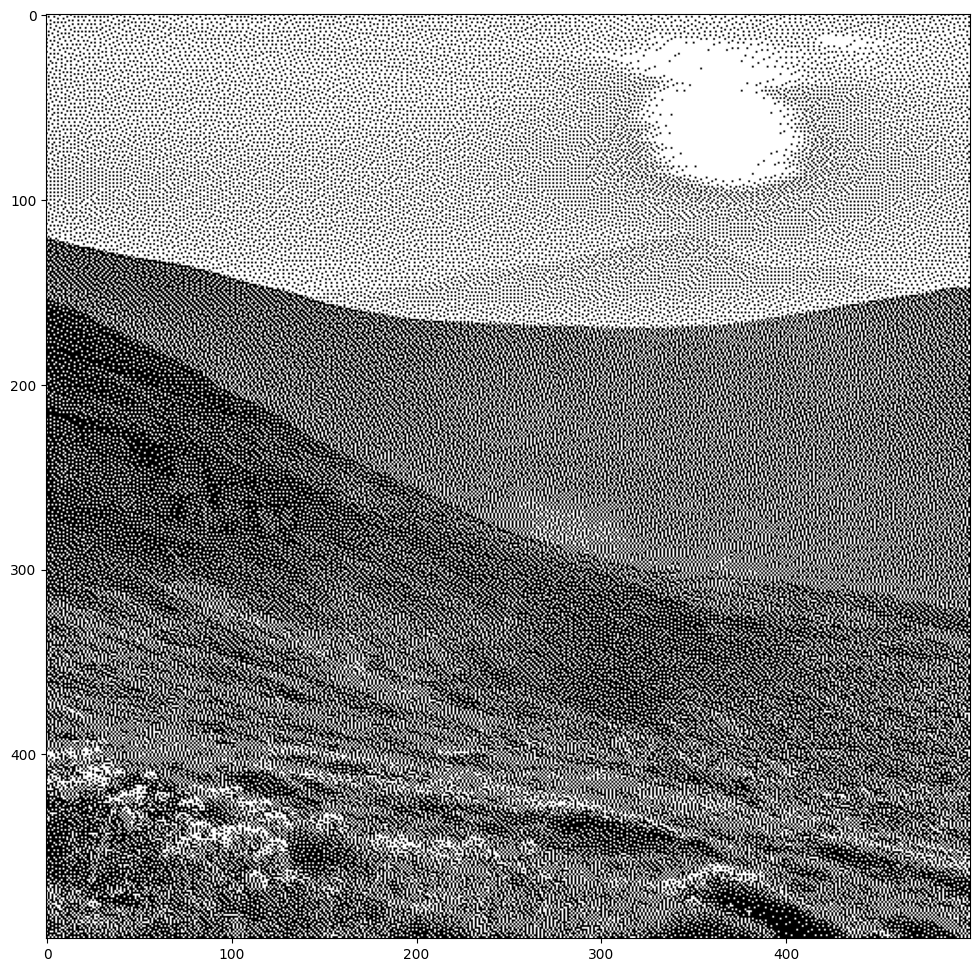

In [18]:
def show_zoom(dithering):
    plt.figure(figsize=(16,12))
    plt.imshow(dithering[200:700, 200:700])   # dithering

print('Number of colors used: ', len({tuple(c) for r in dithering for c in r}))
show_zoom(dithering)

In [19]:
# Compute average quantization error for dithered image
# PNSR
show_psnr(dithering, img)

PSNR (dB): 6.7140447171338735


### Bonus Points

Repeat the homework using a diffrerent image pallette. For instance, you can use an optimal colour
pallette that we can calculate via k-means algorithm. The following snippet of code will give you the 16
optimal colours for your original image.

In [20]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=32, n_init=1).fit(np.reshape(img, (-1, 3)))
colors = kmeans.cluster_centers_.astype(np.uint8)
print(colors)

[[ 73  85 121]
 [225 175 140]
 [ 28  38  57]
 [129 106  22]
 [168  91 113]
 [152 134 151]
 [ 45  49  17]
 [165 128  92]
 [111  77  57]
 [ 43  85 132]
 [253 227 144]
 [204 128 125]
 [141  18 112]
 [123  95 108]
 [ 15  20  32]
 [ 87  82  87]
 [ 72 104 155]
 [ 69  60  51]
 [170 134  40]
 [237 195 166]
 [ 51  63  81]
 [200 154  77]
 [251 230 205]
 [ 88  80  15]
 [214  24 152]
 [191 160 153]
 [243 101 176]
 [112 113 148]
 [253 237  84]
 [ 14  63 107]
 [141 106  65]
 [246 202 131]]


Quantized shape: (1356, 2048, 3)


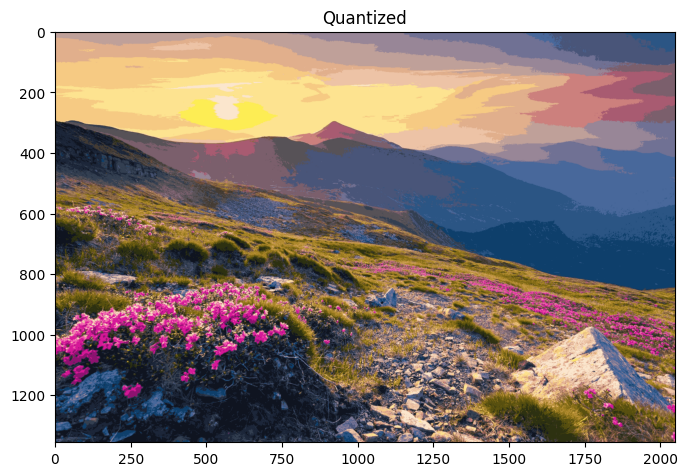

In [21]:
quantized = quantize(img, colors)

In [22]:
show_psnr(quantized, img)

PSNR (dB): 26.4991341503867


In [23]:
dithering = dither(img, colors)

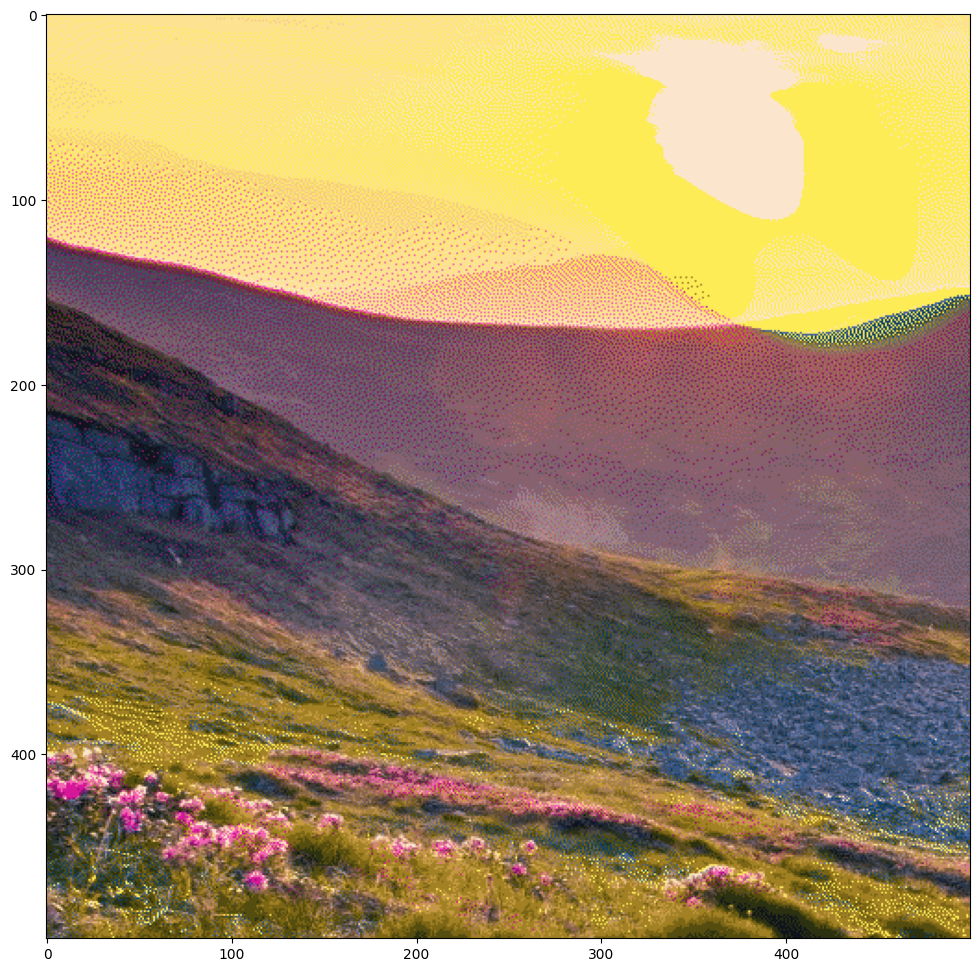

In [ ]:
show_zoom(dithering)

In [ ]:
show_psnr(dithering, img)

PSNR (dB): 19.51702505795677


Apply FS dithering the same way you did before.
* How does the result look like to you?
* What happens if we use 32 colours?
* And what happens if we use 256 colours?

# Answers
- Looks colorful :) And the colors match those on original image quite good. Also 16 colors pallette gives much more detalization when not using dithering. For dithering the error is in generally lower,  which leads to interesting results, as on the area of sky on the image, no visual effect of gradient is added. So, essentially dithering is visible more rarely. Looks like for RGB space and such a colorful image 16 colors is not enough to cover the needs. PSNR is around 20, earlier it was 6-9.
- The image looks really good, the quantized version is not yet natural, but has great detalization. The dithering gives a result that has an appearance of original image if not zoomed. When zoomed, dithering artifacts have high contrast in few areas only. PSNR is slightly better.
- The quantization set my laptop on fire. But I suppose, there would be almost no difference between quantization, dithering, and the original image. The margins between colors would be small so the dithering artifacts magnitude would be very low.